# Задание
* Скачать все вакансии СБЕРа с ХХ (у апи есть ограничение в 2000, а также captcha подумайте как их можно обойти)
* Извлеките все описания этих вакансий
* Создайте аналогичный vacancy DataFrame только добавьте поле skills
* Переведите даты публикаций в datetime
* Постройте график опубликованных вакансий по датам
* Переведите даты в дни недели, и определите день недели, в который больше всего публикуют вакансий
* Найдите те вакансии с использованием python, которые вам интересны
* Определите по полю skills какие навыки больше всего востребованы для этих вакансий
* Постройте график наиболее востребованных навыков для аналитика данных

In [284]:
import requests
import json
from tqdm.auto import tqdm
from tqdm import notebook
from collections import defaultdict
import pickle
import pandas as pd

### Скачаем все вакансии СБЕРа в Москве

Подключимся к api HH, указав ID Сбера на этом сайте и параметры для считывания страниц. Выгрузим вакансии только по Москве:

In [581]:
sber = '3529'
page = 1
num_per_page = 100
moscow = 1
url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}&area={moscow}'

Посмотрим, сколько вакансий нашлось:

In [582]:
res = requests.get(url)

res.json().get('found')

1104

Посмотрим, сколько всего вакансий у Сбера на сайте:

In [583]:
r = requests.get(f'https://api.hh.ru/vacancies?employer_id={sber}&page={page}&per_page={num_per_page}').json().get('found')
r

3425

Получается, вакансии в Москве составляют практически 1/3 от всех вакансий ((1104/3425)*100=32%).

Узнаем, на скольких страницах находятся наши 1104 вакансии:

In [584]:
res.json().get('pages')

12

### Извлечём все описания этих вакансий

Сохраним результат полученного запроса в переменную vacancies и считаем его ключи:

In [585]:
vacancies = res.json()
vacancies.keys()

dict_keys(['items', 'found', 'pages', 'per_page', 'page', 'clusters', 'arguments', 'alternate_url'])

Описание вакансий находится в 'items', сохраним их в отдельную переменную:

In [586]:
all_vacancy_items= []
for i in tqdm(range(vacancies.get('pages'))):
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={i}&per_page={num_per_page}&area={moscow}'
    res = requests.get(url)
    vacancy_items = res.json().get('items')
    all_vacancy_items.extend(vacancy_items)

Проверим, что выгрузили все вакансии:

In [587]:
len(all_vacancy_items)

1104

Сохраним выгруженное описание вакансий в датафрэйм:

In [588]:
data_vac = pd.DataFrame(all_vacancy_items)

# посмотрим на структуру данных
data_vac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1104 non-null   object
 1   premium                   1104 non-null   bool  
 2   name                      1104 non-null   object
 3   department                1104 non-null   object
 4   has_test                  1104 non-null   bool  
 5   response_letter_required  1104 non-null   bool  
 6   area                      1104 non-null   object
 7   salary                    62 non-null     object
 8   type                      1104 non-null   object
 9   address                   428 non-null    object
 10  response_url              5 non-null      object
 11  sort_point_distance       0 non-null      object
 12  published_at              1104 non-null   object
 13  created_at                1104 non-null   object
 14  archived                

In [589]:
# посмотрим на сами данные
data_vac.head(3)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,relations,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,immediate_redirect_url
0,55415805,False,Менеджер по работе с клиентами,"{'id': '3529-3529-stat', 'name': 'Сбер. Начало...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 98800, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,[],"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Опыт работы консультантом или...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN
1,55415496,False,Клиентский менеджер прямых продаж,"{'id': '3529-3529-stat', 'name': 'Сбер. Начало...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 98800, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,[],"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...","{'requirement': None, 'responsibility': 'Выезж...",None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN
2,66978838,False,Специалист по адаптации (onboarding manager),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,[],"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Опыт работы в IT-компании. Ра...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN


### Создадим аналогичный DataFrame, добавив поле со skills

Сохраним id вакансий в отдельный список:

In [590]:
all_vacancy_ids= []
for i in tqdm(range(vacancies.get('pages'))):
    url = f'https://api.hh.ru/vacancies?employer_id={sber}&page={i}&per_page={num_per_page}&area={moscow}'
    res = requests.get(url)
    vacancies = res.json()
    vacancy_ids = [el.get('id') for el in vacancies.get('items')]
    all_vacancy_ids.extend(vacancy_ids)

На основе полученных id можем выгрузить дополнительное описание каждой вакансии, сохраним их в датафрэйм:

In [591]:
vak_url = 'https://api.hh.ru/vacancies/{}'

var = []
for i in all_vacancy_ids:
    var.append(requests.get(vak_url.format(i)).json())

In [592]:
skills = pd.DataFrame(var)   

# посмотрим на структуру данных
skills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1104 entries, 0 to 1103
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            1104 non-null   object
 1   premium                       1104 non-null   bool  
 2   billing_type                  1104 non-null   object
 3   relations                     1104 non-null   object
 4   name                          1104 non-null   object
 5   insider_interview             0 non-null      object
 6   response_letter_required      1104 non-null   bool  
 7   area                          1104 non-null   object
 8   salary                        62 non-null     object
 9   type                          1104 non-null   object
 10  address                       428 non-null    object
 11  allow_messages                1104 non-null   bool  
 12  experience                    1104 non-null   object
 13  schedule          

In [593]:
# посмотрим на сами данные
skills.head(3)

,id,premium,billing_type,relations,name,insider_interview,response_letter_required,area,salary,type,...,apply_alternate_url,has_test,test,alternate_url,working_days,working_time_intervals,working_time_modes,accept_temporary,languages,immediate_redirect_url
0,55415805,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Менеджер по работе с клиентами,None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 98800, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/55415805,[],[],[],False,[],NaN
1,55415496,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Клиентский менеджер прямых продаж,None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 98800, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/55415496,[],[],[],False,[],NaN
2,66978838,False,"{'id': 'standard', 'name': 'Стандарт'}",[],Специалист по адаптации (onboarding manager),None,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/applicant/vacancy_response?vacan...,False,None,https://hh.ru/vacancy/66978838,[],[],[],False,[],NaN


Посмотрим, как выглядит поле таблицы с навыками:

In [594]:
skills[['id','key_skills']].head()

,id,key_skills
0,55415805,[]
1,55415496,[]
2,66978838,"[{'name': 'Многозадачность'}, {'name': 'Провед..."
3,53361761,"[{'name': 'Активные продажи'}, {'name': 'Прове..."
4,67157362,[]


Такой формат нам не подходит, преобразуем навыки в списки:

In [595]:
vak_url = 'https://api.hh.ru/vacancies/{}'

var_skills = []
for i in all_vacancy_ids:
    var_skills.append([x.get('name') for x in requests.get(vak_url.format(i)).json().get('key_skills')])

Добавим полученные списки навыков в отдельный столбец датафрэйма:

In [596]:
skills['key_skills_list'] = var_skills
skills['key_skills_list'].head()

0                                                   []
1                                                   []
2    [Многозадачность, Проведение опросов, Google C...
3    [Активные продажи, Проведение презентаций, При...
4                                                   []
Name: key_skills_list, dtype: object

Сохраним столбец с навыками и id вакансии в отдельную таблицу:

In [597]:
skill_id = skills[['id', 'key_skills_list']]
skill_id.head()

,id,key_skills_list
0,55415805,[]
1,55415496,[]
2,66978838,"[Многозадачность, Проведение опросов, Google C..."
3,53361761,"[Активные продажи, Проведение презентаций, При..."
4,67157362,[]


Добавим навыки в таблицу data_vac, объединим таблицы по id вакансии в качестве ключа:

In [598]:
data_vac_skill = pd.merge(data_vac, skill_id, on='id', how='left')

data_vac_skill.head(3)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,immediate_redirect_url,key_skills_list
0,55415805,False,Менеджер по работе с клиентами,"{'id': '3529-3529-stat', 'name': 'Сбер. Начало...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 98800, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Опыт работы консультантом или...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,[]
1,55415496,False,Клиентский менеджер прямых продаж,"{'id': '3529-3529-stat', 'name': 'Сбер. Начало...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 98800, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",None,...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...","{'requirement': None, 'responsibility': 'Выезж...",None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,[]
2,66978838,False,Специалист по адаптации (onboarding manager),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,"{'id': '3529', 'name': 'СБЕР', 'url': 'https:/...",{'requirement': 'Опыт работы в IT-компании. Ра...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Многозадачность, Проведение опросов, Google C..."


### Переведём даты публикаций в datetime

In [599]:
# перевожу из строки в дату и время

data_vac['published_at'] = pd.to_datetime(data_vac['published_at'], format='%Y-%m-%d %H:%M:%S')

# проверяю формат отображения и тип данных 

data_vac['published_at'].head()

0   2022-06-29 13:44:54+03:00
1   2022-06-29 19:44:36+03:00
2   2022-06-20 09:55:10+03:00
3   2022-06-27 12:47:08+03:00
4   2022-06-24 12:22:12+03:00
Name: published_at, dtype: datetime64[ns, pytz.FixedOffset(180)]

### Построим график опубликованных вакансий по датам

Создадим столбец с датами публикации:

In [600]:
data_vac['published_date'] = data_vac['published_at'].dt.date

Посчитаем, сколько вакансий было опубликовано в каждую дату:

In [601]:
published_date = data_vac.groupby('published_date')['id'].count() 

published_date 

published_date
2022-06-06     38
2022-06-07     26
2022-06-08     29
2022-06-09     32
2022-06-10     35
2022-06-11      2
2022-06-14     64
2022-06-15     49
2022-06-16     53
2022-06-17     42
2022-06-18      2
2022-06-19      2
2022-06-20     69
2022-06-21     57
2022-06-22     62
2022-06-23     61
2022-06-24     55
2022-06-25      3
2022-06-26     32
2022-06-27    103
2022-06-28     72
2022-06-29     75
2022-06-30     78
2022-07-01     44
2022-07-02      5
2022-07-03     14
Name: id, dtype: int64

Построим график на основе полученных данных:

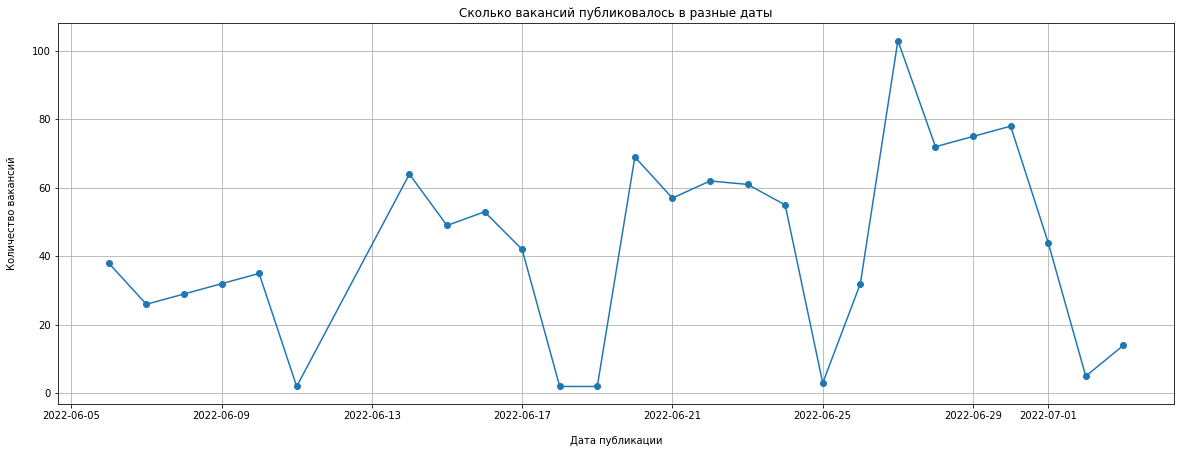

In [602]:
import matplotlib.pyplot as plt

published_date.plot(grid=True, figsize=(20,7), marker='o')
plt.title('Сколько вакансий публиковалось в разные даты')
plt.xlabel('Дата публикации', labelpad = 15)
plt.ylabel('Количество вакансий', labelpad = 15);

Дата 2022-06-27 оказалась самым популярным днём для публикаций.

### Переведём даты в дни недели и определим день, в который больше всего публикуют вакансий

Создадим столбец с днями недели:

In [603]:
data_vac['published_day_of_week'] = data_vac['published_at'].dt.day_name()

Посчитаем, сколько вакансий было опубликовано в каждый день недели:

In [604]:
published_day_of_week = data_vac.groupby('published_day_of_week')['id'].count() 

published_day_of_week 

published_day_of_week
Friday       176
Monday       210
Saturday      12
Sunday        48
Thursday     224
Tuesday      219
Wednesday    215
Name: id, dtype: int64

Построим график на основе полученных данных:

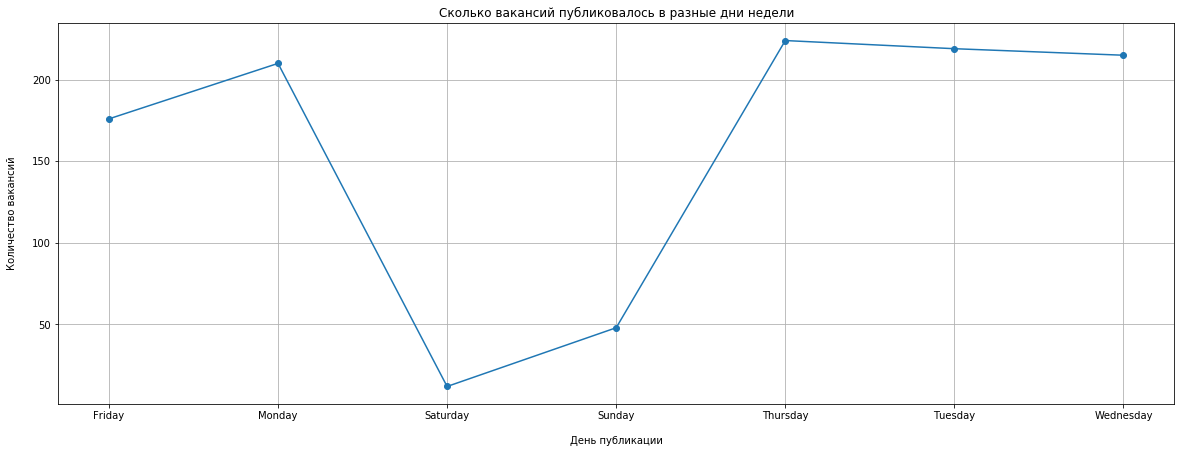

In [605]:
published_day_of_week.plot(grid=True, figsize=(20,7), marker='o')
plt.title('Сколько вакансий публиковалось в разные дни недели')
plt.xlabel('День публикации', labelpad = 15)
plt.ylabel('Количество вакансий', labelpad = 15);

С совсем небольшим отрывом четверг и вторник оказались в лидерах, за ними - среда, затем - понедельник и пятница.

### Найдём интересные вакансии с использованием python

Создадим функцию, которая ищет упоминание Python в описании навыков для вакансии:

In [606]:
# создадим функцию, которая ищет Python в навыках
def python(key_skills_list):
    if 'Python' in key_skills_list:
        return 'Python' 
    if 'python' in key_skills_list:
        return 'Python'     

# создадим новый столбец для вакансий с пометкой Python, выделенным с помощью функции
data_vac_skill['Python'] = data_vac_skill['key_skills_list'].apply(python)

# посчитаем, сколько таких вакансий нашлось
data_vac_skill['Python'].value_counts()

Python    120
Name: Python, dtype: int64

Нашлось 120 вакансий с упоминанием Python. Посмотрим на пример данных с вакансиями, где в требованиях есть Python:

In [616]:
data_vac_skill_python = data_vac_skill[data_vac_skill['Python'].notnull()]

data_vac_skill_python.head(3)

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,immediate_redirect_url,key_skills_list,Python,analyst
33,67255863,False,Junior Python разработчик (Цифровой кредитный ...,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Python, SQL, Hive, Spark, Git]",Python,None
35,66832293,False,QA инженер (медицина),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[SQL, Python, Java, Функциональное тестировани...",Python,None
65,54682944,False,Data Scientist (Рекомендательная система),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Python, Numpy, Pandas, Математическая статист...",Python,None


Среди них нас интересуют вакансии для аналитиков:

In [617]:
# создадим функцию, которая ищет Аналитиков 
def analyst(name):
    if 'Аналитик' in name:
        return 'Аналитик' 
    if 'аналитик' in name:
        return 'Аналитик'     
    if  'Analyst' in name:
        return 'Аналитик'     
    if 'analyst' in name:
        return 'Аналитик'        

# создадим новый столбец для этих вакансий 
data_vac_skill_python['analyst'] = data_vac_skill_python['name'].apply(analyst)

# посчитаем, сколько таких вакансий нашлось
data_vac_skill_python['analyst'].value_counts()

C:\Users\luky\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Аналитик    14
Name: analyst, dtype: int64

Нашлось всего 14 таких вакансий, посмотрим на них:

In [618]:
analyst = data_vac_skill_python[data_vac_skill_python['analyst'].notnull()]
analyst

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,immediate_redirect_url,key_skills_list,Python,analyst
69,66523856,False,Аналитик SQL,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[SQL, Python]",Python,Аналитик
121,67138099,False,Дата аналитик,"{'id': '3529-3529-lead', 'name': 'Сбер. Экспер...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[SQL, Python, Оперативный поиск информации в с...",Python,Аналитик
147,67406605,False,Data Analyst SberDevices,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Python, SQL, Анализ данных, ML, pandas, A/B т...",Python,Аналитик
171,66633113,False,Data Analyst,"{'id': '3529-3529-data', 'name': 'Сбер. Data S...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[SQL, Python]",Python,Аналитик
197,55138654,False,Data Analyst (Рекомендательная система),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Python, SQL, PostgreSQL, Git, Atlassian Jira]",Python,Аналитик
213,66888602,False,Product analyst,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Python, SQL, Анализ данных, Аналитическое мыш...",Python,Аналитик
215,66807414,False,Аналитик в команду кампейнинга,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Analysis, SQL, Python, Кампании продаж, Кампе...",Python,Аналитик
232,66099561,False,Data аналитик (Рекламная платформа),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Python, SQL, Data Mining, Oracle BI, Анализ д...",Python,Аналитик
352,55856164,False,Data аналитик,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[SQL, Bash, Atlassian Jira, Python, Jenkins]",Python,Аналитик
370,66099734,False,Системный аналитик (Рекламная платформа),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Python, REST, UML, BPMN, Atlassian Jira, SQL,...",Python,Аналитик


Как видно в названиях самих вакансий сферы для работы совершенно разные: есть и SberDevices, и рекламные платформы, и управленческая отчётность. Все вакансии на полный день, 3 из них - в центральном офисе на Кутузовском проспекте.

### Определим по полю skills, какие навыки больше всего востребованы для этих вакансий

Соединим описания навыков из всех строк в один список:

In [619]:
lst = sum(analyst['key_skills_list'], [])

# посмотрим, сколько навыков набралось всего (неуникальных)
len(lst)

84

In [620]:
# посмотрим на сам список
lst

['SQL',
 'Python',
 'SQL',
 'Python',
 'Оперативный поиск информации в сети Интернет',
 'Qlik Sense',
 'Статистический анализ',
 'Python',
 'SQL',
 'Анализ данных',
 'ML',
 'pandas',
 'A/B тесты',
 'Ad Hoc Analysis',
 'SQL',
 'Python',
 'Python',
 'SQL',
 'PostgreSQL',
 'Git',
 'Atlassian Jira',
 'Python',
 'SQL',
 'Анализ данных',
 'Аналитическое мышление',
 'Analysis',
 'SQL',
 'Python',
 'Кампании продаж',
 'Кампейнинг',
 'Excel',
 'Teradata',
 'Spark',
 'Data Analysis',
 'Data Analyst',
 'Python',
 'SQL',
 'Data Mining',
 'Oracle BI',
 'Анализ данных',
 'SQL',
 'Bash',
 'Atlassian Jira',
 'Python',
 'Jenkins',
 'Python',
 'REST',
 'UML',
 'BPMN',
 'Atlassian Jira',
 'SQL',
 'SOAP',
 'Java',
 'MS SQL',
 'Бизнес-анализ',
 'Разработка технических заданий',
 'DWH',
 'Hadoop',
 'Python',
 'Atlassian Jira',
 'Atlassian Confluence',
 'SQL',
 'Python',
 'Математическая статистика',
 'Математический анализ',
 'MS PowerPoint',
 'Hadoop',
 'SQL',
 'Hive',
 'Spark',
 'Python',
 'SQL',
 'Python

Посчитаем, сколько раз в списке встречается каждый навык:

In [621]:
unique = dict(zip(list(lst),[list(lst).count(i) for i in list(lst)]))
unique

{'SQL': 13,
 'Python': 14,
 'Оперативный поиск информации в сети Интернет': 1,
 'Qlik Sense': 1,
 'Статистический анализ': 1,
 'Анализ данных': 3,
 'ML': 1,
 'pandas': 1,
 'A/B тесты': 1,
 'Ad Hoc Analysis': 1,
 'PostgreSQL': 1,
 'Git': 1,
 'Atlassian Jira': 4,
 'Аналитическое мышление': 1,
 'Analysis': 1,
 'Кампании продаж': 2,
 'Кампейнинг': 2,
 'Excel': 1,
 'Teradata': 2,
 'Spark': 3,
 'Data Analysis': 2,
 'Data Analyst': 1,
 'Data Mining': 1,
 'Oracle BI': 1,
 'Bash': 1,
 'Jenkins': 1,
 'REST': 1,
 'UML': 1,
 'BPMN': 1,
 'SOAP': 1,
 'Java': 1,
 'MS SQL': 1,
 'Бизнес-анализ': 1,
 'Разработка технических заданий': 1,
 'DWH': 1,
 'Hadoop': 2,
 'Atlassian Confluence': 1,
 'Математическая статистика': 1,
 'Математический анализ': 1,
 'MS PowerPoint': 1,
 'Hive': 1,
 'CRM': 1,
 'СБЕР': 1,
 'x-sell': 1,
 'Аналитик': 1,
 'Аналитик данных': 1,
 'Big Data': 1}

Преобразуем полученный словарь в датафрэйм, зададим названия колонок:

In [622]:
skill_table = pd.DataFrame(unique.items(), columns=['Skill', 'Count'])

skill_table.head()

,Skill,Count
0,SQL,13
1,Python,14
2,Оперативный поиск информации в сети Интернет,1
3,Qlik Sense,1
4,Статистический анализ,1


Добавим ещё один столбец, в котором посчитаем, какую долю по упоминаниям в вакансиях составляет каждый навык в общем списке:

In [623]:
skill_table['Ratio'] = round((skill_table['Count'] / skill_table['Skill'].nunique()) * 100,0)

skill_table

,Skill,Count,Ratio
0,SQL,13,28.0
1,Python,14,30.0
2,Оперативный поиск информации в сети Интернет,1,2.0
3,Qlik Sense,1,2.0
4,Статистический анализ,1,2.0
5,Анализ данных,3,6.0
6,ML,1,2.0
7,pandas,1,2.0
8,A/B тесты,1,2.0
9,Ad Hoc Analysis,1,2.0


Посмотрим на топ-5 самых востребованных навыков в отдельную переменную:

In [624]:
skill_table.sort_values(by='Count', ascending=False).head()

,Skill,Count,Ratio
1,Python,14,30.0
0,SQL,13,28.0
12,Atlassian Jira,4,9.0
5,Анализ данных,3,6.0
19,Spark,3,6.0


Как мы видим, самым востребованным ожидаемо является знание Python (встречается в 30% вакансий). Знание SQL - на втором месте (28%). Остальные три навыка по сравнению с первыми двумя встречаются гораздо реже в требованиях (6% и 9%).

### Построим график наиболее востребованных навыков для аналитика данных

Найдём вакансии для аналитиков данных:

In [629]:
# создадим функцию, которая ищет Аналитиков данных
def data_analyst(name):
    if 'Аналитик данных' in name:
        return 'Аналитик данных' 
    if 'аналитик данных' in name:
        return 'Аналитик данных'     
    if 'Data analyst' in name:
        return 'Аналитик данных'     
    if 'data analyst' in name:
        return 'Аналитик данных'       
    if 'Data аналитик' in name:
        return 'Аналитик данных'     
    if 'data аналитик' in name:
        return 'Аналитик данных'      

# создадим новый столбец для вакансий
data_vac_skill['data_analyst'] = data_vac_skill['name'].apply(data_analyst)

# посчитаем, сколько таких вакансий нашлось
data_vac_skill['data_analyst'].value_counts()

Аналитик данных    10
Name: data_analyst, dtype: int64

Посмотрим на эти вакансии:

In [630]:
data_analyst = data_vac_skill[data_vac_skill['data_analyst'].notnull()]

data_analyst

,id,premium,name,department,has_test,response_letter_required,area,salary,type,address,...,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary,immediate_redirect_url,key_skills_list,Python,data_analyst
39,67073420,False,Аналитик данных/ Разработчик отчетности,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,[],None,Аналитик данных
45,67260355,False,Junior data analyst,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[SQL, ETL, Hadoop, XML, Spark]",None,Аналитик данных
94,67346866,False,Аналитик данных (campaign analyst),"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,[],None,Аналитик данных
232,66099561,False,Data аналитик (Рекламная платформа),"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Python, SQL, Data Mining, Oracle BI, Анализ д...",Python,Аналитик данных
317,67272273,False,Data analyst в Блок Финансы,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,[],None,Аналитик данных
352,55856164,False,Data аналитик,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[SQL, Bash, Atlassian Jira, Python, Jenkins]",Python,Аналитик данных
436,66554726,False,Data analyst,"{'id': '3529-3529-it', 'name': 'Сбер. IT'}",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,[],None,Аналитик данных
459,66920043,False,Аналитик данных,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,[],None,Аналитик данных
690,67256606,False,Data analyst (DWH),"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}",None,...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,"[Hadoop, SQL, Hive, Spark, Python]",Python,Аналитик данных
709,67061564,False,Аналитик данных под ЕСС (единый семантический ...,"{'id': '3529-3529-prof', 'name': 'Сбер для экс...",False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...",None,"{'id': 'open', 'name': 'Открытая'}","{'city': 'Москва', 'street': 'Кутузовский прос...",...,None,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False,NaN,[],None,Аналитик данных


По аналогии с аналитиками определим востребованные скиллы для аналитиков данных:

In [637]:
lst_data_analyst = sum(data_analyst['key_skills_list'], [])
unique_data_analyst = dict(zip(list(lst_data_analyst),[list(lst_data_analyst).count(i) for i in list(lst_data_analyst)]))

Сохраним в отдельную таблицу и также добавим таблицу с долей навыка в общем списке, дополнительно отсортируем навыки по востребованности:

In [638]:
skill_table_data_analyst = pd.DataFrame(unique_data_analyst.items(), columns=['Skill', 'Count'])

skill_table_data_analyst['Ratio'] = round((skill_table_data_analyst['Count'] / \
                                           skill_table_data_analyst['Skill'].nunique()) * 100,0)

# сортируем по востребованности
skill_table_data_analyst = skill_table_data_analyst.sort_values(by='Count', ascending=False)

# посмотрим на итоговый список
skill_table_data_analyst

,Skill,Count,Ratio
0,SQL,4,31.0
5,Python,3,23.0
2,Hadoop,2,15.0
4,Spark,2,15.0
1,ETL,1,8.0
3,XML,1,8.0
6,Data Mining,1,8.0
7,Oracle BI,1,8.0
8,Анализ данных,1,8.0
9,Bash,1,8.0


Снова SQL и Python в абсолютных лидерах: доли 31% и 23% соответственно.

Определим топ-5 навыков:

In [642]:
top5_skills = skill_table_data_analyst.sort_values(by='Count', ascending=False).head()
top5_skills

,Skill,Count,Ratio
0,SQL,4,31.0
5,Python,3,23.0
2,Hadoop,2,15.0
4,Spark,2,15.0
1,ETL,1,8.0


На основе таблицы топ-5 построим круговую диаграмму, где также определим долю каждого навыка внутри топ-5:

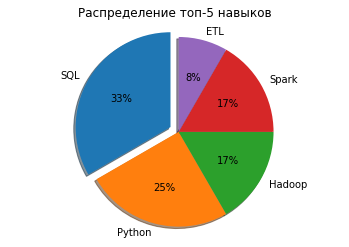

In [641]:
labels = top5_skills['Skill']
sizes = top5_skills['Count']

explode = (0.1, 0, 0, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.0f%%', shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Распределение топ-5 навыков')
plt.show()